In [1]:
import os
import pandas
import numpy
import math
import matplotlib
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Settings
accuracy = 0.95
number_of_bootstraps = 100
filename = "MA_Public_Schools_2017.csv"
start_year = 2010
stop_year = 2017
y_column_name = "% Graduated"
y_groups = 2
ignore_columns = [
    "High School Graduates (#)",
    "% Dropped Out",
    "% Still in School",
    "School Code",
    "School Name",
    "Contact Name",
    "Address 1",
    "Address 2",
    "Town",
    "State",
    "Zip",
    "Phone",
    "Fax",
    "District Name",
    "% Still in School",
    "% Non-Grad Completers",
    "% GED",
    "% Dropped Out",
    "% Permanently Excluded",
    "High School Graduates (#)",
    "Attending Coll./Univ. (#)",
    "Accountability and Assistance Description",
    "District_Accountability and Assistance Description",
    "District Code",
]
one_hot_encode = ["School Type", "Function"]
floatify_columns = ["AP_Test Takers", "AP_Tests Taken"]
levelize_columns = ["Accountability and Assistance Level", "District_Accountability and Assistance Level"]
gradify_columns = ["Grade"]

In [3]:
# Load the data
df = pandas.read_csv(filename)

In [4]:
df

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,...,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
0,10505,Abington High,Public School,Principal,Teresa Sullivan-Cruz,201 Gliniewicz Way,NaN,Abington,MA,2351,...,111.0,Level 1,Meeting gap narrowing goals,42.0,76.0,75.0,Level 3,One or more schools in the district classified...,63.0,60.0
1,10003,Beaver Brook Elementary School,Public School,Principal,Catherine Zinni,1 Ralph Hamlin Lane,NaN,Abington,MA,2351,...,NaN,Level 3,Among lowest performing 20% of subgroups,34.0,69.0,73.0,Level 3,One or more schools in the district classified...,63.0,60.0
2,10002,Center Elementary School,Public School,Principal,Lora Monachino,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Level 3,One or more schools in the district classified...,63.0,60.0
3,10405,Frolio Middle School,Public School,Principal,Matthew MacCurtain,201 Gliniewicz Way,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,40.0,63.0,64.0,Level 3,One or more schools in the district classified...,63.0,60.0
4,10015,Woodsdale Elementary School,Public School,Principal,Jonathan Hawes,128 Chestnut Street,NaN,Abington,MA,2351,...,NaN,Level 2,Not meeting gap narrowing goals,52.0,65.0,67.0,Level 3,One or more schools in the district classified...,63.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,35060505,Pioneer Charter School of Science II (PCSS-II),Charter School,Principal,Vahit Sevinc,97 Main Street,NaN,Saugus,MA,1906,...,30.0,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1857,35100205,Springfield Preparatory Charter School,Charter School,Principal,Bill Spirer,370 Pine St.,NaN,Springfield,MA,1105,...,NaN,Insufficient data,NaN,NaN,NaN,NaN,Insufficient data,NaN,NaN,NaN
1858,39020900,TEC Connections Academy Commonwealth Virtual S...,Public School,Principal,Adam Goldberg,141 Mansion Drive,NaN,East Walpole,MA,2032,...,28.0,Level 3,Very low assessment participation (Less than 90%),NaN,NaN,NaN,Level 3,Very low assessment participation (Less than 90%),NaN,NaN
1859,35050405,UP Academy Charter School of Dorchester,Charter School,Principal,Jabari Peddie,35 Westville Street,NaN,Boston,MA,2124,...,NaN,Level 1,Meeting gap narrowing goals,35.0,92.0,98.0,Level 1,Meeting gap narrowing goals,92.0,98.0


In [5]:
for column in df.columns:
    print(column)

School Code
School Name
School Type
Function
Contact Name
Address 1
Address 2
Town
State
Zip
Phone
Fax
Grade
District Name
District Code
PK_Enrollment
K_Enrollment
1_Enrollment
2_Enrollment
3_Enrollment
4_Enrollment
5_Enrollment
6_Enrollment
7_Enrollment
8_Enrollment
9_Enrollment
10_Enrollment
11_Enrollment
12_Enrollment
SP_Enrollment
TOTAL_Enrollment
First Language Not English
% First Language Not English
English Language Learner
% English Language Learner
Students With Disabilities
% Students With Disabilities
High Needs
% High Needs
Economically Disadvantaged
% Economically Disadvantaged
% African American
% Asian
% Hispanic
% White
% Native American
% Native Hawaiian, Pacific Islander
% Multi-Race, Non-Hispanic
% Males
% Females
Total # of Classes
Average Class Size
Number of Students
Salary Totals
Average Salary
FTE Count
In-District Expenditures
Total In-district FTEs
Average In-District Expenditures per Pupil
Total Expenditures
Total Pupil FTEs
Average Expenditures per Pupil
# i

In [6]:
df.isna().sum().sum()

380677

In [7]:
df_encoded = df.copy()

In [8]:
numpy.array(df_encoded["School Type"]).reshape(-1, 1)

array([['Public School'],
       ['Public School'],
       ['Public School'],
       ...,
       ['Public School'],
       ['Charter School'],
       ['Charter School']], dtype=object)

In [9]:
for column_name in one_hot_encode:
    encoder = OneHotEncoder(sparse=False)
    column = numpy.array(df_encoded[column_name][df_encoded[column_name].notna()]).reshape(-1, 1)
    encoder.fit(column)
    indices = df_encoded[column_name][df_encoded[column_name].notna()].index
    for i in range(len(encoder.categories_[0])):
        new_column_name = column_name + ": " + encoder.categories_[0][i]
        df_encoded = pandas.merge(df_encoded, pandas.DataFrame({new_column_name: encoder.transform(column)[:, i]}), left_index = True, right_index = True)
    df_encoded = df_encoded.drop(column_name, 1)

In [10]:
# Fix Data
df_clean = df_encoded

for column in floatify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is str:
            df_clean.loc[row, column] = float(df_clean.loc[row, column].replace(',', ''))

for column in levelize_columns:
    for row in range(df_clean.shape[0]):
        value = df_clean.loc[row, column]
        if value == "Insufficient data":
            df_clean.loc[row, column] = numpy.nan
        elif value == "Level 1":
            df_clean.loc[row, column] = 1
        elif df_clean.loc[row, column] == "Level 2":
            df_clean.loc[row, column] = 2
        elif df_clean.loc[row, column] == "Level 3":
            df_clean.loc[row, column] = 3
        elif df_clean.loc[row, column] == "Level 4":
            df_clean.loc[row, column] = 4
        elif df_clean.loc[row, column] == "Level 5":
            df_clean.loc[row, column] = 5

grades = ["PK", "K", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

for grade in grades:
    df_clean["Grade " + grade] = numpy.full(df_clean.shape[0], 0)

for column in gradify_columns:
    for row in range(df_clean.shape[0]):
        if type(df_clean.loc[row, column]) is not float:
            for current_grade in df_clean.loc[row, column].replace("0", "").split(","):
                df_clean.loc[row, "Grade " + current_grade] = 1

    df_clean = df_clean.drop(column, 1)

In [11]:
df_clean.isna().sum().sum()

380929

In [12]:
# Columns that were removed
for column in df.columns:
    if column not in df_clean.columns:
        print(column)

School Type
Function
Grade


In [13]:
# Get rid of errored/confusing data
df_slim = df_clean
for column in ignore_columns:
    if column in df_slim.columns:
        df_slim = df_slim.drop(column, 1)

In [14]:
df_slim.shape

(1861, 295)

In [15]:
df[y_column_name].describe()

count    376.000000
mean      83.327394
std       21.459396
min        0.000000
25%       82.150000
50%       92.250000
75%       96.200000
max      100.000000
Name: % Graduated, dtype: float64

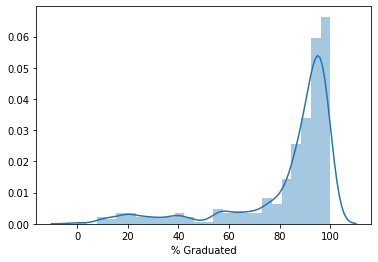

In [16]:
seaborn.distplot(df[y_column_name][df[y_column_name].notna()])

In [17]:
df[y_column_name].isna().sum() / df.shape[0]

0.7979580870499732

In [18]:
df_fixed_y_column = df_slim[df_slim[y_column_name].notna()]
df_fixed_y_column.shape

(376, 295)

In [19]:
df_fixed_y_column[y_column_name] = OrdinalEncoder().fit_transform(numpy.array(df_fixed_y_column[y_column_name] > df_fixed_y_column[y_column_name].mean()).reshape(-1, 1))
df_fixed_y_column[y_column_name]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       1.0
8       1.0
16      1.0
17      0.0
23      1.0
       ... 
1826    0.0
1831    1.0
1838    1.0
1851    0.0
1858    0.0
Name: % Graduated, Length: 376, dtype: float64

In [20]:
accuracy_scores = []
jaccard_scores = []
probabilities = []
coefs = {}

for column in df_fixed_y_column.columns:
    if column != y_column_name:
        coefs[column] = []

for run in range(number_of_bootstraps):
    print("Run {0}".format(run))
    
    # Split X and Y
    x = df_fixed_y_column.drop(y_column_name, 1)
    y = df_fixed_y_column[y_column_name]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    # Recombine the X and Y of the training data
    df_train = pandas.merge(pandas.DataFrame(x_train), pandas.DataFrame(y_train), left_index=True, right_index=True)
    
    # Balance the groups in the training data (with resampling)
    lengths = []
    for group_index in range(y_groups):
        group_1_len = df_train[df_train[y_column_name] == 1].shape[0]
    df_train = pandas.concat([
        df_train[df_train[y_column_name] == 1],
        resample(df_train[df_train[y_column_name] == 0], n_samples=group_1_len)
    ])
    
    # Resplit X and Y
    x_train = df_train.drop(y_column_name, 1)
    y_train = df_train[y_column_name]
    
    # Create the pipeline
    imputer = IterativeImputer() # Fills in the N/A's using similar entries and regression
    scaler = RobustScaler() # Center and scale the values
    selector = SelectFromModel(RidgeClassifierCV()) # Select the most important features
    model = LogisticRegressionCV(solver="liblinear") # Fit a logistic model
    pipeline = Pipeline(steps=[
        ("imputer", imputer),
        ("scaler", scaler),
        ("selector", selector),
        ("model", model)
    ])
    
    # Pipeline Classification
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    probabilities.append(pipeline.predict_proba(x_test))
    
    # Accuracy Score
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Jaccard Score
    jaccard_scores.append(jaccard_score(y_test, y_pred))
    
    # Feature Importances
    for index in range(len(model.coef_[0])):
        column = x_train.columns[index]
        coef = model.coef_[0][index]
        coefs[column].append(coef)

Run 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 7


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 8


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 9


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 11


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 12


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 13


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 14


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 15


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 16


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 17


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 18


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 20


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 21


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 22


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 23


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 24


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 25


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 26


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 27


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 28


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 29


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 30


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 31


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 32


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 33


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 34


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 35


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 36


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 37


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 38


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 39


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 40


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 41


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 42


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 43


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 44


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 45


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 46


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 47


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 48


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 49


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 50


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 51


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 52


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 53


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 54


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 55


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 56


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 57


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 58


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 59


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 60


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 61


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 62


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 63


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 65


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 66


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 67


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 69


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 70


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 71


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 72


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 73


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 74


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 75


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 76


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 77


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 78


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 79


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 80


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 81


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 82


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 83


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 84


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 85


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 86


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 87


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 88


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 89


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 90


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 91


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 92


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 93


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 95


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 96


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 97


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 98


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Run 99


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


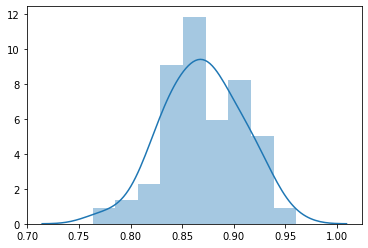

In [21]:
seaborn.distplot(accuracy_scores)

In [22]:
partial_accuracy = (1-accuracy) / 2
accuracy_scores_sorted = sorted(accuracy_scores)
estimate = accuracy_scores_sorted[int(number_of_bootstraps / 2)]
lower_ci = accuracy_scores_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = accuracy_scores_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.868 (0.789, 0.934)


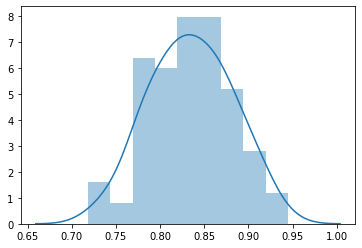

In [23]:
seaborn.distplot(jaccard_scores)

In [24]:
partial_accuracy = (1-accuracy) / 2
jaccard_scores_sorted = sorted(jaccard_scores)
estimate = jaccard_scores_sorted[int(number_of_bootstraps / 2)]
lower_ci = jaccard_scores_sorted[int(number_of_bootstraps * partial_accuracy)]
upper_ci = jaccard_scores_sorted[int(number_of_bootstraps * (1-partial_accuracy))]
print("{0:.3f} ({1:.3f}, {2:.3f})".format(estimate, lower_ci, upper_ci))

0.836 (0.741, 0.921)


In [25]:
pop_list = []
for key, value in coefs.items():
    if len(value) < number_of_bootstraps:
        pop_list.append(key)
for key in pop_list:
    coefs.pop(key)
partial_accuracy = (1-accuracy) / 2

def item_magnitude(item):
    sorted_values = sorted(item[1])
    lower_ci = sorted_values[int(number_of_bootstraps * partial_accuracy)]
    upper_ci = sorted_values[int(number_of_bootstraps * (1-partial_accuracy))]
    return abs(abs(lower_ci)-abs(upper_ci))

magnitudes = []

for key, value in {k: v for k, v in sorted(coefs.items(), key=item_magnitude, reverse=True)}.items():
    sorted_values = sorted(value)
    estimate = sorted_values[int(number_of_bootstraps / 2)]
    lower_ci = sorted_values[int(number_of_bootstraps * partial_accuracy)]
    upper_ci = sorted_values[int(number_of_bootstraps * (1-partial_accuracy))]
    magnitudes.append(abs(abs(lower_ci)-abs(upper_ci)))

magnitudes_scaler = MinMaxScaler()
magnitudes_scaler.fit(numpy.array(magnitudes).reshape(-1, 1))

for key, value in {k: v for k, v in sorted(coefs.items(), key=item_magnitude, reverse=True)}.items():
    sorted_values = sorted(value)
    estimate = sorted_values[int(number_of_bootstraps / 2)]
    lower_ci = sorted_values[int(number_of_bootstraps * partial_accuracy)]
    upper_ci = sorted_values[int(number_of_bootstraps * (1-partial_accuracy))]
    magnitude = abs(abs(lower_ci)-abs(upper_ci))
    magnitude_scaled = magnitudes_scaler.transform(numpy.array(magnitude).reshape(-1, 1))
    direction = ""
    if abs(lower_ci) > abs(upper_ci):
        direction = "-"
    elif abs(upper_ci) > abs(lower_ci):
        direction = "+"
    print("{0:<50.50}| {1:4.4f} ({2:4.4f}, {3:4.4f}),   \t| {4}{5:4.4f}".format(key, estimate, lower_ci, upper_ci, direction, magnitude_scaled[0][0]))

TOTAL_Enrollment                                  | -0.3113 (-10.9593, 2.5276),   	| -1.0000
11_Enrollment                                     | -0.9548 (-13.1565, 5.1896),   	| -0.9437
Students With Disabilities                        | -0.2450 (-10.1460, 3.0529),   	| -0.8378
% African American                                | 0.0227 (-6.6756, 13.3565),   	| +0.7878
12_Enrollment                                     | -1.0890 (-9.7163, 3.2878),   	| -0.7573
AP_Score=1                                        | -0.1251 (-10.5699, 4.4144),   	| -0.7242
PK_Enrollment                                     | 0.5813 (-1.0700, 6.8059),   	| +0.6733
Economically Disadvantaged                        | -0.0370 (-4.9266, 10.5107),   	| +0.6549
3_Enrollment                                      | 0.2561 (-4.2610, 9.7213),   	| +0.6399
8_Enrollment                                      | -0.4791 (-10.2917, 5.1226),   	| -0.6047
AP_Two Tests                                      | 0.0699 (-3.6240, 7.8656)

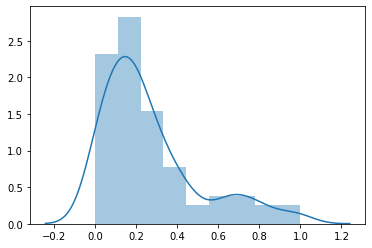

In [26]:
seaborn.distplot(magnitudes_scaler.transform(numpy.array(magnitudes).reshape(-1, 1)))

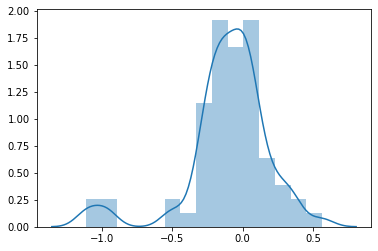

In [27]:
coef_medians = []
for coef_array in coefs.values():
    coef_median = pandas.Series(coef_array).median()
    if coef_median is not numpy.nan and coef_median != 0.0:
        coef_medians.append(pandas.Series(coef_array).median())
seaborn.distplot(coef_medians)

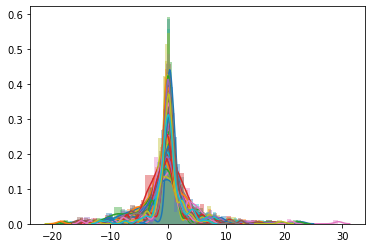

In [28]:
for key, value in coefs.items():
    seaborn.distplot(value)

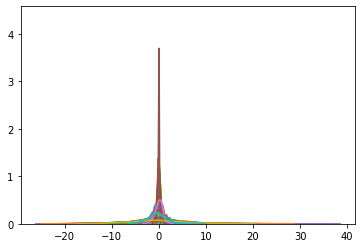

In [29]:
for i in range(number_of_bootstraps):
    this_set = []
    for key, value in coefs.items():
        this_set.append(value[i])
    seaborn.distplot(this_set)